# Customer Segmentation of Arvato-Bertelsmann customers

## Summary 

lore ipsum

## I. Introduction

The Arvato-Group is one of total 8 business units in the Bertelsmann Group which is a worldwide operating service company head-quarted in Germany.<br>
The main operating field of Avarto are logistics- and supply chain services and solutions, financial services as well as the operation of IT Systems. Concerning the general figures to get a grasp of the company, the company employs a staff around 77.342 persons (2020) and generates a sales volume of 5.56 Mrd. EUR per a (2024).

The present project can be localized in the financial services branch of Arvato (Arvato Financial Solutions).<br><br>
<span style="color: green;">**One client of Arvato Financial Solutions, a Mail-Order Company selling organic products, wants to be advised concerning a more efficient way to acquire new clients.<br>
In essence, the company wants their acquisition marketing campaings instead of reaching out to everyone (costly), target more precisely those persons which show the highest probability to turn into new customers.**</span>
<br><br>
<span style="text-decoration: underline;">The project spans two main tasks:</span>
1) Customer Segmentation: An Analysis of the existing customer database dataset is carried out and on this basis a general recommandation of which people in Germany are most likely to be new customers of the company is generated. <br><br>
2) Modelling Campaign-Responses: Using the results of 1) to build a machine learning model that predicts whether or not an individual will respond to the respective campaign.

This notebook focuses on the first main task.




## II. Methodology

* General description how we'll proceed
* Short description of the datasets at hand
* Exploratory Analysis of the two datasets
* Short plan what needs to be done to clean the dataset for further use
* PCA of bigger ds
* PCA application on customer ds
* Clustering 

<img src = '../data/img/procedure_segmentation.PNG'/>

#### General description of the methodology

#### Import relevant libraries and load the data

In [101]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', None)

import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,kurtosis

%matplotlib inline

In [102]:
#load the relevant data
root_path = os.path.dirname(os.getcwd())

azdias = pd.read_csv(rf'{root_path}\data\Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv(rf'{root_path}\data\Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

mapping_information_level = pd.read_excel(rf'{root_path}\data\DIAS Information Levels - Attributes 2017.xlsx', sheet_name='mapping')

#### Description of the datasets at hand

There are four data files associated with this project:

1) `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
2) `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
3) `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
4) `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

#############<br>
Whereas the first two files are rather relevant for the customer segmentation (first main task), the later two dataset are more relevant for the second main task (Modelling Campaign-Responses).<br>

The azdias-dataset and the customers-dataset show only a small difference concerning the attributes / columns

In [103]:
np.setdiff1d(
    np.array(customers.columns),
    np.array(azdias.columns),
    assume_unique=True
)

array(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype=object)

Hence, the description of the columns of the datasets at hand can be combined due to the large amount of common columns.<br>
In general, the datasets 1. and 2. contain data where one record describes one individual person over a large amount of attributes-

Arvato provided two excel files containing column-descriptions for the data relevant for the project.
The columns can be distinguished on an "information level" into:<br> 
* <span style="text-decoration: underline;"> **> Person:**</span> data describing the indvidual at hand e.g. age, sex, financial topology, nationality etc.<br><br>
* <span style="text-decoration: underline;"> **> Household:**</span> data describing the circumstances within the household the indivual lives in e.g. no of persons in household, academic titles in household, children in household, transaction activity in Household etc.<br><br>
* <span style="text-decoration: underline;"> **> Building:**</span> data describing the building the household is localized e.g. number of households in the building, type of building, neighbourhood-area indicator etc.<br><br>
* <span style="text-decoration: underline;"> **> Microcell (RR4_ID):**</span> data describing the respective "microcell" (the individual belongs to) by the CAMEO consumer classifications system. <br><br>
* <span style="text-decoration: underline;"> **> Microcell (RR3_ID):**</span> data describing the respective "microcell" (the individual belongs to) by attributes concerning mobility / cars. <br><br>
* <span style="text-decoration: underline;"> **> 125m x 125m Grid**</span> data describing the transactional activity of the individual.<br><br>
* <span style="text-decoration: underline;"> **> Postcode:**</span> data describing the rather geographical context the individual lives in.<br><br>
* <span style="text-decoration: underline;"> **> RR1_ID**</span> data describing the neighbourhood of the individual.<br><br>
* <span style="text-decoration: underline;"> **> PLZ8**</span> data describing the respective geographical area (the individual belongs to) by attributes concerning mobility / cars.<br><br>
* <span style="text-decoration: underline;"> **> Community**</span> data describing the neighbourhood of the individual.

In [104]:
print(f"The azdias dataset has {azdias.shape[0]} rows and {azdias.shape[1]} columns.")
print(f"The customer dataset (of Avarto) has {customers.shape[0]} rows and {customers.shape[1]} columns.")

The azdias dataset has 891221 rows and 366 columns.
The customer dataset (of Avarto) has 191652 rows and 369 columns.


Looking at the information level grouping element, the data can be divided (after some adaptions in the excel file) as follows: 

In [105]:
attribute_df = customers.columns.to_frame().reset_index(drop = True).rename({0: "Attributes"}, axis = 1)
mapping = mapping_information_level[["Attribute", "Information level"]].set_index("Attribute").to_dict(orient="dict", index = True)["Information level"]
attribute_df["info_level"] = attribute_df["Attributes"].map(mapping).fillna("other")

attribute_df.groupby("info_level").count().sort_values(by = "Attributes", ascending=False).T

info_level,PLZ8,Microcell (RR3_ID),125m x 125m Grid,Person,Household,other,Building,RR1_ID,Community,Microcell (RR4_ID),Postcode
Attributes,123,63,49,43,40,28,9,5,3,3,3


After having now a certain grasp in which logical categories the data can be classified. We'll have a look which datatypes are present in the datasets:

In [106]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
Name: count, dtype: int64

To close the description of the datasets and proceed to EDA, in the following the attributes under the information level are listed with their respective datatype:

In [107]:
for info_lvl in attribute_df["info_level"].unique():

    df_tmp = attribute_df[attribute_df["info_level"] == info_lvl]

    print(f"Information Level: {info_lvl}\n")
    for col in df_tmp["Attributes"]:
        print(f"{col}, (dtype: {customers[col].dtype})")
        
    print("#"*100, "\n")

Information Level: Person

LNR, (dtype: int64)
AGER_TYP, (dtype: int64)
CJT_GESAMTTYP, (dtype: float64)
FINANZ_ANLEGER, (dtype: int64)
FINANZ_HAUSBAUER, (dtype: int64)
FINANZ_MINIMALIST, (dtype: int64)
FINANZ_SPARER, (dtype: int64)
FINANZ_UNAUFFAELLIGER, (dtype: int64)
FINANZ_VORSORGER, (dtype: int64)
FINANZTYP, (dtype: int64)
GEBURTSJAHR, (dtype: int64)
GFK_URLAUBERTYP, (dtype: float64)
GREEN_AVANTGARDE, (dtype: int64)
HEALTH_TYP, (dtype: int64)
LP_FAMILIE_FEIN, (dtype: float64)
LP_FAMILIE_GROB, (dtype: float64)
LP_LEBENSPHASE_FEIN, (dtype: float64)
LP_LEBENSPHASE_GROB, (dtype: float64)
LP_STATUS_FEIN, (dtype: float64)
LP_STATUS_GROB, (dtype: float64)
NATIONALITAET_KZ, (dtype: int64)
PRAEGENDE_JUGENDJAHRE, (dtype: int64)
RETOURTYP_BK_S, (dtype: float64)
SEMIO_DOM, (dtype: int64)
SEMIO_ERL, (dtype: int64)
SEMIO_FAM, (dtype: int64)
SEMIO_KAEM, (dtype: int64)
SEMIO_KRIT, (dtype: int64)
SEMIO_KULT, (dtype: int64)
SEMIO_LUST, (dtype: int64)
SEMIO_MAT, (dtype: int64)
SEMIO_PFLICHT, (dtype: 

#### Exploratory Data Analysis

##### (1) What are the general statistical moments of the different attributes of the datasets? 

To get a general understanding of the distinct attributes below the 5 descriptive moment of the two datasets are shown. <br>
It is noticeable that:
* there are 8 attributes which are of the datatype 'object' which should be adressed in data preparation.
* there are several attributes with missing values which has to be investigated further and adressed in data preparation.
* there are at first sight a lot of attributes with skewed distributions 
* there are at first sight a lot of attributes with non-zero kurtosis  

In [108]:
def calc_stat_moments(df):
    """Calculate the 5 general statistical moments of the columns of the given dataframe:
    (0) Non Null Cnt (1) Mean (2) Variance (3) Skewness (4) Kurtosis

    Args:
        df (pandas.DataFrame): Pandas DataFrame to calculate the moments for

    Returns:
        pd.DataFrame with the statistical Moments
    """

    df_ = pd.Series(df.columns.tolist()).to_frame().rename({0: "Attributes"}, axis=1)
    df_["dtype"] = [df[col].dtype for col in df.columns]
    df_["non null cnt"] = [df[col].shape[0] - df[col].isnull().sum() for col in df.columns]
    df_["mean_mode"] = [np.round(df[col].mean().item(),2) if df[col].dtype.kind in "biufc" else df[col].mode()[0] for col in df.columns]
    df_["std"] = [np.round(df[col].var().item(),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    df_["skewnness"] = [np.round(skew(df[col].dropna(), axis = 0, bias = True),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    df_["curtosis"] = [np.round(kurtosis(df[col].dropna(), axis = 0, bias = True),2) if df[col].dtype.kind in "biufc" else "not numerical" for col in df.columns]
    
    return df_

In [109]:
calc_stat_moments(azdias)

,Attributes,dtype,non null cnt,mean_mode,std,skewnness,curtosis
0,LNR,int64,891221,637263.0,66189646838.5,-0.0,-1.2
1,AGER_TYP,int64,891221,-0.36,1.44,1.52,0.74
2,AKT_DAT_KL,float64,817722,4.42,13.24,0.29,-1.77
3,ALTER_HH,float64,817722,10.86,58.36,-0.43,-1.36
4,ALTER_KIND1,float64,81058,11.75,16.79,-0.14,-1.03
5,ALTER_KIND2,float64,29499,13.4,10.52,-0.42,-0.6
6,ALTER_KIND3,float64,6170,14.48,7.36,-0.68,-0.05
7,ALTER_KIND4,float64,1205,15.09,6.02,-0.77,-0.05
8,ALTERSKATEGORIE_FEIN,float64,628274,13.7,25.8,-1.05,1.2
9,ANZ_HAUSHALTE_AKTIV,float64,798073,8.29,244.24,8.78,142.62


In [110]:
calc_stat_moments(customers)

,Attributes,dtype,non null cnt,mean_mode,std,skewnness,curtosis
0,LNR,int64,191652,95826.5,3060890063.0,-0.0,-1.2
1,AGER_TYP,int64,191652,0.34,1.94,0.31,-1.49
2,AKT_DAT_KL,float64,145056,1.75,3.87,2.77,6.54
3,ALTER_HH,float64,145056,11.35,39.38,-0.41,-0.64
4,ALTER_KIND1,float64,11766,12.34,16.05,-0.32,-0.93
5,ALTER_KIND2,float64,5100,13.67,10.52,-0.5,-0.56
6,ALTER_KIND3,float64,1275,14.65,7.58,-0.78,0.09
7,ALTER_KIND4,float64,236,15.38,5.33,-0.74,-0.0
8,ALTERSKATEGORIE_FEIN,float64,139810,10.33,17.1,-0.71,1.2
9,ANZ_HAUSHALTE_AKTIV,float64,141725,4.97,204.77,12.06,210.79


##### (2) Missing values

We are dividing this analysis into column-wise and row-wise consideration

**Column-wise consideration**

Focusing on the Top 30 missing value attributes, 
* there are several attributes with very high proportions of missing values by column (e.g. ALTER_KINDx)
* there are several attributes with the same proportion of missing values within the datasets

Looking at all values, it is noticeable that both datasets ~ 95 % of the data has not more than 30 % of missing values, but as stated already above some outlier with many missing values.

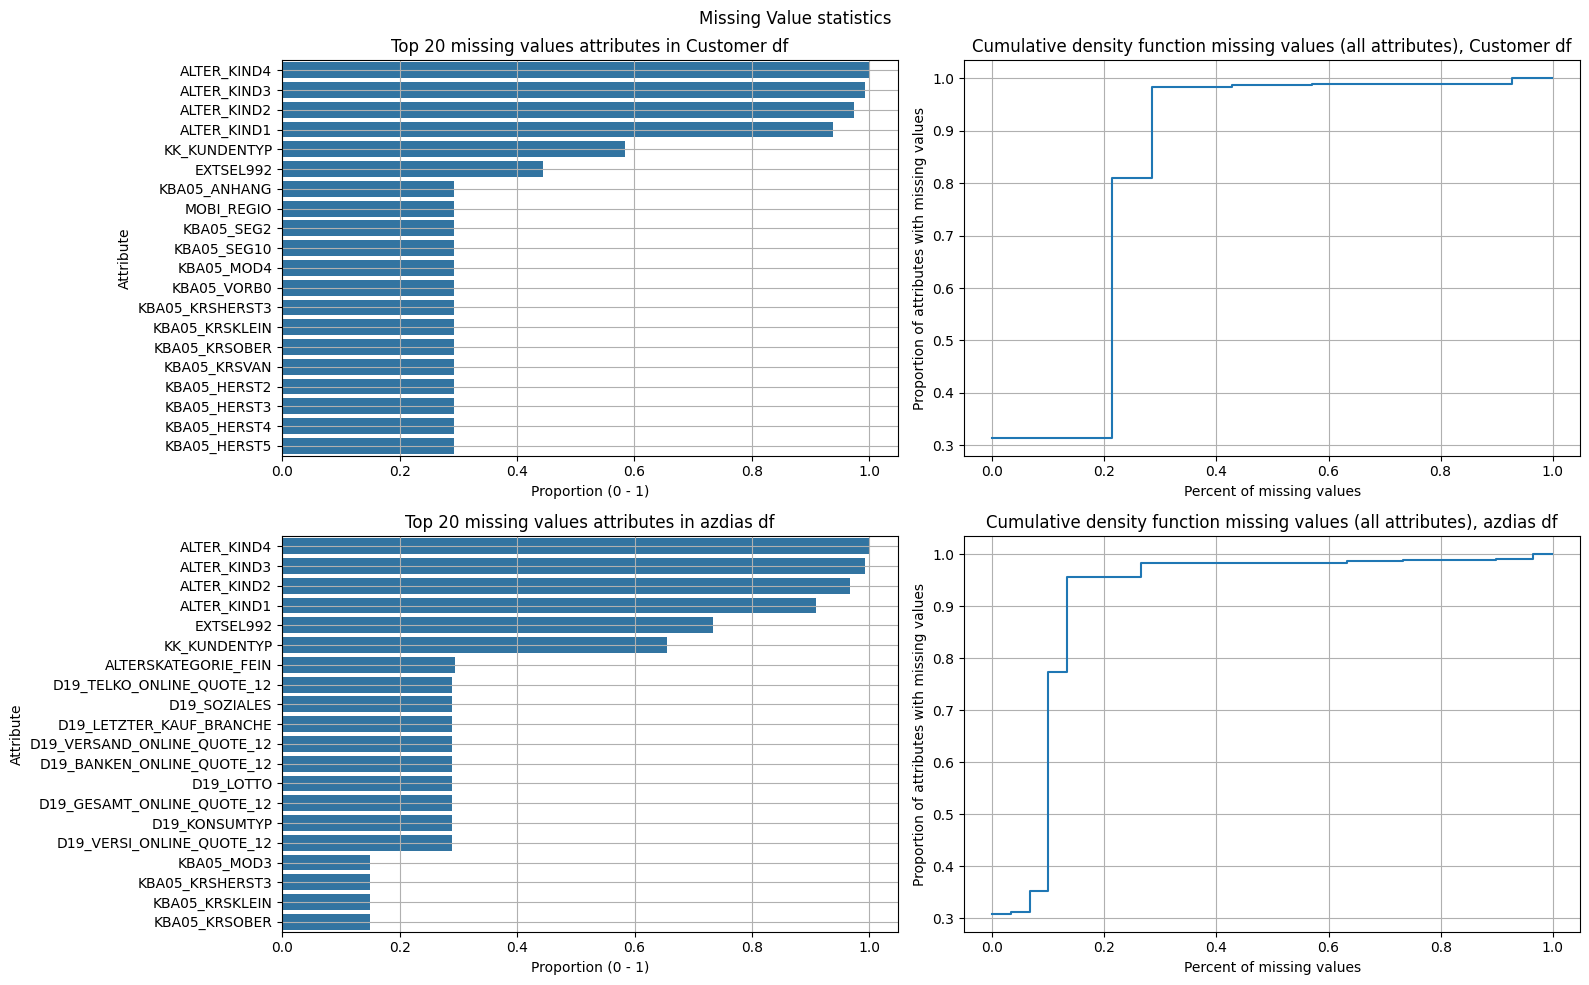

In [111]:
missing_vals_perc_customers = (customers.isnull().sum() / customers.shape[0]).sort_values(ascending=False)
missing_vals_perc_azdias = (azdias.isnull().sum() / azdias.shape[0]).sort_values(ascending=False)

fig, sub = plt.subplots(2, 2, figsize=(16,10))

n = 20

sns.barplot(y = missing_vals_perc_customers.head(n).index, x = missing_vals_perc_customers.head(n), orient = "h", ax = sub[0,0])
sns.histplot(missing_vals_perc_customers, ax = sub[0,1], cumulative=True, kde=False,element='step', stat = "proportion", fill=False)

sns.barplot(y = missing_vals_perc_azdias.head(n).index, x = missing_vals_perc_azdias.head(n), orient = "h", ax = sub[1,0])
sns.histplot(missing_vals_perc_azdias, ax = sub[1,1], cumulative=True, kde=False,element='step', stat = "proportion", fill=False)


[s.grid() for s in sub.flatten()]

#top n missing values ax descr.
[s.set_ylabel("Attribute") for s in [sub[0,0], sub[1,0]]]
[s.set_xlabel("Proportion (0 - 1)") for s in [sub[0,0], sub[1,0]]]

#cdf missing values ax descr.
[s.set_ylabel("Proportion of attributes with missing values") for s in [sub[0,1], sub[1,1]]]
[s.set_xlabel("Percent of missing values") for s in [sub[0,1], sub[1,1]]]

sub[0,0].set_title(f"Top {n} missing values attributes in Customer df")
sub[1,0].set_title(f"Top {n} missing values attributes in azdias df")

sub[0,1].set_title(f"Cumulative density function missing values (all attributes), Customer df")
sub[1,1].set_title(f"Cumulative density function missing values (all attributes), azdias df")

fig.suptitle(f"Missing Value statistics")

fig.tight_layout()

Beside the plots above which provide a good impression of the situation, in the following a missing value summary is created to see a bit more specifically which attribute shows which amount of missing value proportion:

In [112]:
def create_missing_value_summary(df):
    """Create missing value summary of a provided dataframe

    Args:
        df (pandas.DataFrame): dataframe to create the missing val summary from

    Returns:
        pandas.DataFrame: missing value summary
    """


    df_ = pd.concat([
        df.isnull().sum().reset_index(name="missing_vals"),
        np.round(df.isnull().sum().reset_index(name="missing_vals_perc")["missing_vals_perc"] / df.shape[0], 2)
    ], axis = 1)

    df_.rename({"index": "Attribute"}, axis = 1, inplace = True)
    df_ = df_[df_["missing_vals"] != 0]

    return df_.sort_values(by = "missing_vals_perc", ascending=False)

In [113]:
missing_value_summary = pd.merge(
    left = create_missing_value_summary(azdias),
    right = create_missing_value_summary(customers),
    how = "outer",
    left_on = "Attribute", 
    right_on= "Attribute",
    suffixes=["_azdias", "_customers"])

In [114]:
missing_value_summary.sort_values("missing_vals_perc_customers", ascending=False)

,Attribute,missing_vals_azdias,missing_vals_perc_azdias,missing_vals_customers,missing_vals_perc_customers
6,ALTER_KIND4,890016,1.00,191416,1.00
5,ALTER_KIND3,885051,0.99,190377,0.99
4,ALTER_KIND2,861722,0.97,186552,0.97
3,ALTER_KIND1,810163,0.91,179886,0.94
230,KK_KUNDENTYP,584612,0.66,111937,0.58
39,EXTSEL992,654153,0.73,85283,0.44
86,KBA05_MAXSEG,133324,0.15,55980,0.29
59,KBA05_CCM1,133324,0.15,55980,0.29
90,KBA05_MOD3,133324,0.15,55980,0.29
89,KBA05_MOD2,133324,0.15,55980,0.29


In [118]:
#create a drop list for columns with missing values > 20 %
missing_perc = azdias.isnull().sum() / azdias.shape[0]
missing_perc[missing_perc>0.2]

ALTER_KIND1                    0.909048
ALTER_KIND2                    0.966900
ALTER_KIND3                    0.993077
ALTER_KIND4                    0.998648
ALTERSKATEGORIE_FEIN           0.295041
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_SOZIALES                   0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
dtype: float64

**Row-wise consideration**

In the customer database, there seem to be a lot of customer ids which show a lot (> 250) nan-values on the attributes:

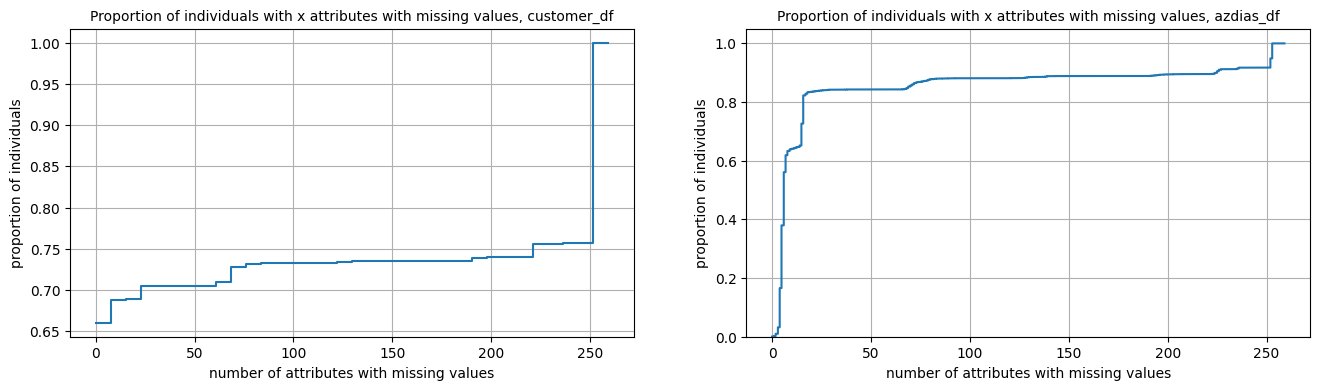

In [93]:
fig, sub = plt.subplots(1,2,figsize = (16,4))

sns.histplot(customers.isnull().sum(axis = 1).sort_values(ascending=True), ax = sub[0], kde=False,element='step', stat = "proportion", fill=False, cumulative=True)
sns.histplot(azdias.isnull().sum(axis = 1).sort_values(ascending=True), ax = sub[1], kde=False,element='step', stat = "proportion", fill=False, cumulative=True)

sub[0].grid()
sub[1].grid()

sub[0].set_xlabel("number of attributes with missing values")
sub[0].set_ylabel("proportion of individuals")
sub[0].set_title("Proportion of individuals with x attributes with missing values, customer_df", fontdict={"size":10})

sub[1].set_xlabel("number of attributes with missing values")
sub[1].set_ylabel("proportion of individuals")
sub[1].set_title("Proportion of individuals with x attributes with missing values, azdias_df",fontdict={"size":10});

In [97]:
customer_null_rowb = customers.isnull().sum(axis = 1)
customer_ls = customer_null_rowb[customer_null_rowb>200].index.tolist()

In [ ]:
customers.loc[customer_ls].isnull().sum() 

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     46596
ALTER_HH                       46596
ALTER_KIND1                    49689
ALTER_KIND2                    49857
ALTER_KIND3                    49951
ALTER_KIND4                    49975
ALTERSKATEGORIE_FEIN           46775
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   49934
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
ANZ_STATISTISCHE_HAUSHALTE     49927
ANZ_TITEL                      46596
ARBEIT                         49928
BALLRAUM                       49927
CAMEO_DEU_2015                 49966
CAMEO_DEUG_2015                49966
CAMEO_INTL_2015                49966
CJT_GESAMTTYP                     97
CJT_KATALOGNUTZER                 97
CJT_TYP_1                         97
CJT_TYP_2                         97
CJT_TYP_3                         97
CJT_TYP_4                         97
CJT_TYP_5                         97
C

Based on this analysis, in the data preparation part of the notebook, it is necessary to adress: 
* the decision which attributes should be rather dropped due to high number of missing values
* the way to handle the attributes with missing values which should not be discarded (e.g. decision on imputation method)

#### Data Preparation

In [63]:
#unknown values mapping (siehe ML Course)
#cols to drop > 20 % 
#missing values on row level

#### Principal Component Analysis

#### Clustering

## III. Results

## IV. Discussion

https://de.wikipedia.org/wiki/Arvato